# Using Random Forests to Predict the Oscars

In [96]:
from __future__ import division
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import YouTubeVideo

In [2]:
hist_oscars = pd.read_excel("DataFiles/MLoscars.xlsx")
hist_oscars.head(5)

,movietitle,index,year,boxoffice,directorage,reviewagg,criticscore,audiencescore,totalfloat,maleper,...,Thriller_sentiment,Trailer_percentOfVolume,Trailer_sent_count,Trailer_sentiment,War Movie_percentOfVolume,War Movie_sent_count,War Movie_sentiment,Word of Mouth_percentOfVolume,Word of Mouth_sent_count,Word of Mouth_sentiment
0,12 Years a Slave,474.5,2014,56667870,45,8.1,96,90,388359,256841,...,0.00,0.74,7,-0.54,4.63,50,-0.75,0.74,7,-1.68
1,127 Hours,1185.0,2011,18335230,55,7.6,93,85,262273,193147,...,0.50,2.78,19,0.91,0.00,0,0.00,1.54,12,-0.04
2,A Beautiful Mind,737.0,2002,170708996,48,8.2,75,93,557026,367628,...,0.24,1.29,21,-0.45,0.27,5,0.75,0.47,7,0.36
3,A Serious Man,1468.5,2010,9042780,53,7.0,89,67,95831,74163,...,-1.75,1.35,7,0.82,0.00,0,0.00,0.45,2,3.13
4,American Beauty,1651.5,2000,130058047,35,8.4,88,93,766470,496476,...,0.27,1.15,43,0.10,0.27,9,0.94,0.79,27,0.12


* From scraping IMDB I gathered 34 different structured data points and reviews.
* I then appeneded the category, sentiment, and sentence count for 50 themes from clarabridge. 

In [3]:
X = hist_oscars.drop(["index","year","releaseyear","totalfloat","reviewagg","status"],1).set_index("movietitle")
#note year, release year were stored as integers. Whoops. Totalfloat, reviewagg are the numbers of ratings and reviews.
#Any correlation with these variables would not be useful for future data
y = hist_oscars.status

In [4]:
percentile = range(5,150,1) #up to 150 features
per_oob_error = [] #out of bag error
features_scores = {}
scores = []

for p in percentile:
	clf = RandomForestClassifier(n_estimators=125, max_features =p/len(X.columns), oob_score= True, n_jobs=-1)
	clf.fit(X,y)
	prediction = clf.predict(X)
	score = clf.score(X,y)
	scores.append(score)
	features = zip(X.columns.values.tolist(), clf.feature_importances_)
	confusion = metrics.confusion_matrix(y, prediction)
	per_oob_error.append(1-clf.oob_score_)
	features_scores[p] = features

In [35]:
print confusion
print score

[[89  0]
 [ 0 16]]
1.0


Our forest is 100% correct in scoring

Let's examine the error rate 

## Plotting the Out of Bag Error Rate

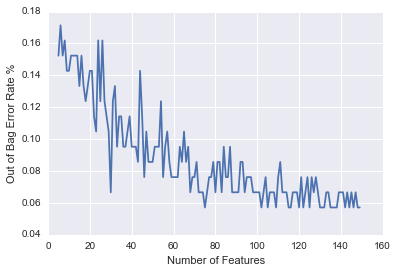

In [6]:
%matplotlib inline
sns.set_style("darkgrid")
plt.plot( percentile, per_oob_error)
plt.xlabel("Number of Features")
plt.ylabel("Out of Bag Error Rate %")
plt.show()

In [8]:
#sort by num features v oob
oob = pd.DataFrame(per_oob_error,percentile, columns=["oob"])

In [95]:
#high feature density, lowest oob
oob[oob["oob"] <.06].T

,75,102,105,109,115,116,120,122,125,130,...,132,135,136,137,138,142,144,146,148,149
oob,0.057143,0.057143,0.057143,0.057143,0.057143,0.057143,0.057143,0.057143,0.057143,0.057143,...,0.057143,0.057143,0.057143,0.057143,0.057143,0.057143,0.057143,0.057143,0.057143,0.057143


In [94]:
#closer to sqrt of number of features
oob[(oob["oob"] < .1)].head(10).T

,30,33,36,37,40,41,42,43,46,48
oob,0.066667,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.085714,0.07619,0.085714


* 30 features seems optimal for balance of OOB v number of features
* 46 features and 75 features will also be run
* Sqrt of features ~14

## Load new new nominees

In [49]:
oscars2016 = pd.read_excel('DataGathering/2016movies2.xlsx')
oscars16themes = pd.read_pickle('DataFiles/oscars16.p')
oscars2016grp = oscars2016.groupby("movietitle").mean()

PredictionOscars = oscars2016grp.join(oscars16themes).fillna(0).drop(["year","releaseyear","totalfloat","reviewagg"],1)

In [50]:
PredictionOscars

,boxoffice,directorage,criticscore,audiencescore,maleper,femaleper,under18,thirtyto44,over44,ones,...,Trailer_sentiment,Violence_percentOfVolume,Violence_sent_count,Violence_sentiment,War Movie_percentOfVolume,War Movie_sent_count,War Movie_sentiment,Word of Mouth_percentOfVolume,Word of Mouth_sent_count,Word of Mouth_sentiment
movietitle,,,,,,,,,,,,,,,,,,,,,
Bridge of Spies,71884220,70,91,88,71268,10966,962,29170,7754,0.5,...,-0.13,0,0,0,4.98,16,-0.28,0.00,0,0.00
Brooklyn,30432320,46,98,90,12687,6621,278,5950,2699,1.1,...,0.00,0,0,0,0.00,0,0.00,0.00,0,0.00
Mad Max: Fury Road,153629485,71,97,86,308855,47696,5163,121382,21256,1.7,...,0.19,0,0,0,0.44,17,-0.26,0.85,35,-0.37
Room,13400000,50,96,94,20887,8435,480,8962,2456,0.8,...,0.56,0,0,0,0.34,1,0.00,1.03,3,0.83
Spotlight,34765827,50,96,95,30737,7776,483,12740,4094,0.9,...,0.55,0,0,0,0.00,0,0.00,0.37,1,0.00
The Big Short,60963697,48,88,89,46718,9126,675,18600,4967,0.8,...,0.05,0,0,0,0.31,1,2.00,0.00,0,0.00
The Martian,227938641,79,92,92,217607,40946,4359,87178,17734,0.6,...,-0.04,0,0,0,0.60,13,1.00,0.69,15,0.60
The Revenant,141677381,53,83,86,129341,23632,2547,47565,9606,0.9,...,0.11,0,0,0,0.63,9,0.11,0.36,4,0.75


In [51]:
#Check to make sure columns are equivalent
for col in PredictionOscars.columns.values:
    if col in X.columns.values:
        pass
    else:
        PredictionOscars = PredictionOscars.drop(col,1)

In [52]:
clf = RandomForestClassifier(n_estimators=125, max_features =75/len(X.columns), oob_score= True, n_jobs=-1)
clf.fit(X,y)


RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features=0.423728813559,
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=125, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0)

In [56]:
zip(PredictionOscars.index.values, clf.predict(PredictionOscars))

[(u'Bridge of Spies', 0),
 (u'Brooklyn', 0),
 (u'Mad Max: Fury Road', 0),
 (u'Room', 0),
 (u'Spotlight', 0),
 (u'The Big Short', 0),
 (u'The Martian', 0),
 (u'The Revenant', 1)]

## The Revenant wins!

In [97]:
YouTubeVideo("https://www.youtube.com/watch?v=LoebZZ8K5N0")

In [61]:
clf.predict_proba(PredictionOscars)

array([[ 0.888,  0.112],
       [ 0.864,  0.136],
       [ 0.808,  0.192],
       [ 0.928,  0.072],
       [ 0.928,  0.072],
       [ 0.96 ,  0.04 ],
       [ 0.928,  0.072],
       [ 0.36 ,  0.64 ]])

In [67]:
probabilities = pd.DataFrame(clf.predict_proba(PredictionOscars), index= PredictionOscars.index.values, columns=["Nominee %", "Winner %"])

In [68]:
probabilities

,Nominee %,Winner %
Bridge of Spies,0.888,0.112
Brooklyn,0.864,0.136
Mad Max: Fury Road,0.808,0.192
Room,0.928,0.072
Spotlight,0.928,0.072
The Big Short,0.960,0.040
The Martian,0.928,0.072
The Revenant,0.360,0.640


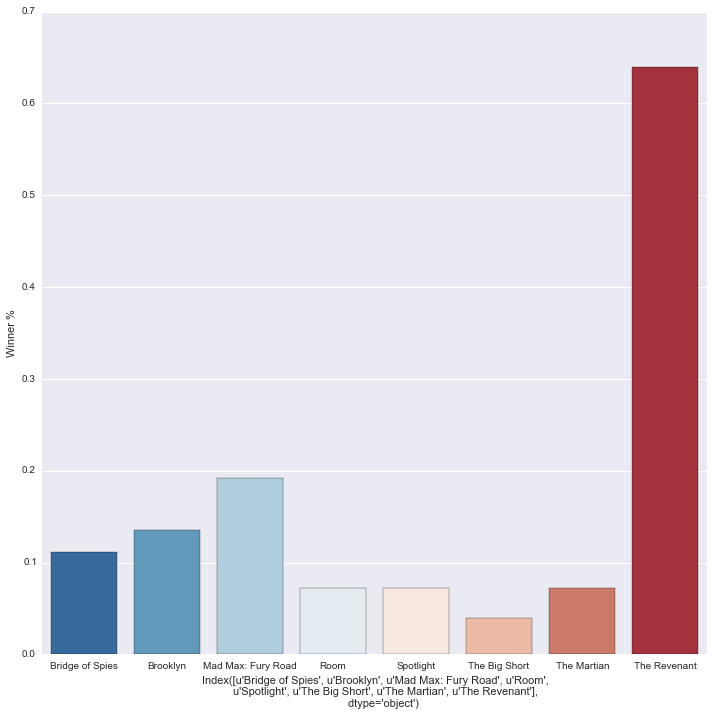

In [89]:
g = sns.factorplot(x=probabilities.index, y="Winner %", data=probabilities,
                   size=10, kind="bar", palette="RdBu_r")